# CSIE5431 ADL HW2 B10705050

## Mount Google Drive

In [2]:
### 1. Google Colab Basics
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path_prefix = "/content/drive/MyDrive/ADL/hw2"

## Setup Evaluation

In [ ]:
!git clone https://github.com/deankuo/ADL24-HW2.git {file_path_prefix}/evaluation

Cloning into '/content/drive/MyDrive/ADL/hw2/evaluation'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 71 (delta 22), reused 26 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (71/71), 18.58 KiB | 1.03 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [4]:
!cd {file_path_prefix}/evaluation && pip install -e tw_rouge

Obtaining file:///content/drive/MyDrive/ADL/hw2/evaluation/tw_rouge
  Preparing metadata (setup.py) ... done
  Running setup.py develop for tw_rouge


## Load Data and Packages

In [5]:
import os
import json
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, Adafactor
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import argparse
import matplotlib.pyplot as plt
from accelerate import Accelerator
from argparse import Namespace

In [ ]:
import sys
sys.path.append(file_path_prefix)
from evaluation.tw_rouge.tw_rouge.twrouge import get_rouge

FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771

but Gdown can't. Please check connections and permissions.

In [6]:
# Define dataset class
class NewsSummaryDataset(Dataset):
    def __init__(self, filepath, tokenizer, max_input_length=256, max_output_length=64, max_train=-1):
        self.data = []
        with open(filepath, "r", encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if max_train != -1 and idx >= max_train:
                    break
                self.data.append(json.loads(line))
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        id = item["id"]
        maintext = item["maintext"]
        title = item["title"]
        inputs = self.tokenizer(
            maintext,
            max_length=self.max_input_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        labels = self.tokenizer(
            title,
            max_length=self.max_output_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels["input_ids"].squeeze(),
            "id": id
        }

## Setting Hyperparameters

In [ ]:
# args = {
#     "model_name": "google/mt5-small",
#     "train_data_path": f"{file_path_prefix}/data/train.jsonl",
#     "model_save_path": f"models",
#     "batch_size": 32,
#     "learning_rate": 5e-5,
#     "epochs": 8,
#     "max_input_length": 256,
#     "max_output_length": 64,
#     "gradient_accumulation_steps": 1,
#     "validation_split": 0.1,
#     "use_fp16": False,
#     "use_adafactor": True
# }

args = {
    "model_name": "google/mt5-small",
    "train_data_path": f"{file_path_prefix}/data/train.jsonl",
    "model_save_path": f"models",
    "batch_size": 24,
    "learning_rate": 5e-5,
    "epochs": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "gradient_accumulation_steps": 5,
    "validation_split": 0.1,
    "use_fp16": False,
    "use_adafactor": True
}


args = Namespace(**args)

# Now you can access attributes using dot notation
print(args.model_name)

google/mt5-small


## Training

In [ ]:
# Initialize Accelerator
accelerator = Accelerator()

# Load pre-trained multilingual T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(args.model_name)

# Prepare dataset
dataset = NewsSummaryDataset(
    filepath=args.train_data_path,
    tokenizer=tokenizer,
    max_input_length=args.max_input_length,
    max_output_length=args.max_output_length,
    # max_train=1000
)

# Split dataset into training and validation if required
if args.validation_split:
    train_size = int((1 - args.validation_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataloader = DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=args.batch_size, shuffle=False
    )
else:
    train_dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    val_dataloader = None

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(args.model_name)

# Prepare model and optimizer
model, optimizer, train_dataloader = accelerator.prepare(
    model,
    (
        Adafactor(
            model.parameters(),
            # lr=args.learning_rate,
            scale_parameter=True,
            relative_step=True,
        )
        if args.use_adafactor
        else torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    ),
    train_dataloader,
)

# Set up training parameters
device = accelerator.device

# Tracking losses
training_losses_per_batch = []
validation_losses_per_epoch = []
rouge_scores_per_epoch = []

# Training loop with progress bar
model.train()
for epoch in range(args.epochs):
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")
    epoch_loss = 0

    for i, batch in enumerate(progress_bar):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        labels[labels == tokenizer.pad_token_id] = -100  # Ignore padding tokens in loss calculation

        assert torch.all(torch.isfinite(input_ids)), "input_ids contains NaN or Inf"
        assert torch.all(torch.isfinite(attention_mask)), "attention_mask contains NaN or Inf"
        assert torch.all(torch.isfinite(labels)), "labels contain NaN or Inf"

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss = loss / args.gradient_accumulation_steps  # Scale loss for gradient accumulation

        # Backward pass
        loss.backward()

        # Update weights and reset gradients if gradient accumulation step is complete
        if (i + 1) % args.gradient_accumulation_steps == 0:
            # Optional: Enable gradient clipping to stabilize training
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()  # Perform optimization step
            optimizer.zero_grad()  # Reset gradients after update

        # Track loss
        epoch_loss += loss.item()
        training_losses_per_batch.append(loss.item())
        progress_bar.set_postfix({"loss": loss.item()})
        if i < 5:
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(train_dataloader)}, Loss: {loss.item()}")

    average_epoch_loss = epoch_loss / len(train_dataloader)

    # Validation loop
    if val_dataloader is not None:
        model.eval()
        val_loss = 0
        references = []
        hypotheses = []
        with torch.no_grad():
            for idx, batch in enumerate(val_dataloader):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                )
                val_loss += outputs.loss.item()

                generated_ids = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=args.max_output_length,
                    num_beams=5,             # Use beam search with more beams for better generation
                    early_stopping=True,     # Stop when all beams have completed
                    temperature=1.0,         # Control randomness in generation
                    top_p=0.95,              # Use nucleus sampling with top-p
                    top_k=50                 # Or top-k sampling to limit the vocabulary
                )

                decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
                decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

                references.extend(decoded_labels)
                hypotheses.extend(decoded_preds)

        val_loss /= len(val_dataloader)
        validation_losses_per_epoch.append(val_loss)
        print(f"Validation Loss after epoch {epoch + 1}: {val_loss}")
        rouge_scores = get_rouge(hypotheses, references)
        rouge_scores_per_epoch.append(rouge_scores)
        print(f"ROUGE Scores after epoch {epoch + 1}: {rouge_scores}")
        model.train()

    # Save model and tokenizer
    state_dict = model.state_dict()
    for name, tensor in state_dict.items():
        if not tensor.is_contiguous():
            state_dict[name] = tensor.contiguous()
    torch.save(state_dict, f"{file_path_prefix}/{args.model_save_path}/fine_tuned_mt5_v3_epoch_{epoch + 1}.pth")
    tokenizer.save_pretrained(f"{file_path_prefix}/{args.model_save_path}/fine_tuned_mt5_v3_epoch_{epoch + 1}")

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
Epoch 1:   0%|          | 1/815 [00:00<08:31,  1.59it/s, loss=4.81]

Epoch 1, Batch 1/815, Loss: 4.810384273529053


Epoch 1:   0%|          | 2/815 [00:01<07:04,  1.91it/s, loss=4.64]

Epoch 1, Batch 2/815, Loss: 4.643802165985107


Epoch 1:   0%|          | 3/815 [00:01<06:44,  2.01it/s, loss=4.21]

Epoch 1, Batch 3/815, Loss: 4.210981369018555


Epoch 1:   0%|          | 4/815 [00:02<06:33,  2.06it/s, loss=3.98]

Epoch 1, Batch 4/815, Loss: 3.975127935409546


Epoch 1:   1%|          | 5/815 [00:02<07:01,  1.92it/s, loss=4.13]

Epoch 1, Batch 5/815, Loss: 4.13063907623291


Epoch 1: 100%|██████████| 815/815 [06:25<00:00,  2.12it/s, loss=0.661]


Validation Loss after epoch 1: 17.537422620333157
ROUGE Scores after epoch 1: {'rouge-1': {'r': 0.17179139416918365, 'p': 0.30086677335125755, 'f': 0.21065908305824557}, 'rouge-2': {'r': 0.06581313999289705, 'p': 0.11648490161644828, 'f': 0.08108312809941969}, 'rouge-l': {'r': 0.1590809752104741, 'p': 0.280249304173217, 'f': 0.1954848770321756}}


Epoch 2:   0%|          | 1/815 [00:00<08:33,  1.58it/s, loss=0.802]

Epoch 2, Batch 1/815, Loss: 0.8021983504295349


Epoch 2:   0%|          | 2/815 [00:01<07:09,  1.89it/s, loss=0.726]

Epoch 2, Batch 2/815, Loss: 0.7262276411056519


Epoch 2:   0%|          | 3/815 [00:01<06:37,  2.04it/s, loss=0.657]

Epoch 2, Batch 3/815, Loss: 0.6568102240562439


Epoch 2:   0%|          | 4/815 [00:01<06:23,  2.11it/s, loss=0.745]

Epoch 2, Batch 4/815, Loss: 0.7445838451385498


Epoch 2:   1%|          | 5/815 [00:02<06:51,  1.97it/s, loss=0.782]

Epoch 2, Batch 5/815, Loss: 0.7824453115463257


Epoch 2: 100%|██████████| 815/815 [06:27<00:00,  2.10it/s, loss=0.694]


Validation Loss after epoch 2: 17.993072887043375
ROUGE Scores after epoch 2: {'rouge-1': {'r': 0.22266700029592384, 'p': 0.32030894123112363, 'f': 0.2542643538124314}, 'rouge-2': {'r': 0.08908980537148559, 'p': 0.12711926303053975, 'f': 0.10128797855525565}, 'rouge-l': {'r': 0.2023932231719818, 'p': 0.2917172984222199, 'f': 0.2311727253857785}}


Epoch 3:   0%|          | 1/815 [00:00<08:08,  1.67it/s, loss=0.6]

Epoch 3, Batch 1/815, Loss: 0.5995303988456726


Epoch 3:   0%|          | 2/815 [00:01<07:03,  1.92it/s, loss=0.572]

Epoch 3, Batch 2/815, Loss: 0.5717471837997437


Epoch 3:   0%|          | 3/815 [00:01<06:38,  2.04it/s, loss=0.579]

Epoch 3, Batch 3/815, Loss: 0.5789873003959656


Epoch 3:   0%|          | 4/815 [00:01<06:27,  2.09it/s, loss=0.578]

Epoch 3, Batch 4/815, Loss: 0.577777087688446


Epoch 3:   1%|          | 5/815 [00:02<06:51,  1.97it/s, loss=0.594]

Epoch 3, Batch 5/815, Loss: 0.5936440825462341


Epoch 3: 100%|██████████| 815/815 [06:27<00:00,  2.10it/s, loss=0.521]


Validation Loss after epoch 3: 19.936778603019295
ROUGE Scores after epoch 3: {'rouge-1': {'r': 0.22787072172397416, 'p': 0.3182819911764668, 'f': 0.25723241416017756}, 'rouge-2': {'r': 0.09013932277069144, 'p': 0.1263754922792823, 'f': 0.10188051942260648}, 'rouge-l': {'r': 0.20581856972741347, 'p': 0.28828522281390234, 'f': 0.23252880206488433}}


Epoch 4:   0%|          | 1/815 [00:00<07:50,  1.73it/s, loss=0.537]

Epoch 4, Batch 1/815, Loss: 0.5374796390533447


Epoch 4:   0%|          | 2/815 [00:01<07:00,  1.93it/s, loss=0.481]

Epoch 4, Batch 2/815, Loss: 0.4807140529155731


Epoch 4:   0%|          | 3/815 [00:01<06:37,  2.04it/s, loss=0.519]

Epoch 4, Batch 3/815, Loss: 0.5189404487609863


Epoch 4:   0%|          | 4/815 [00:01<06:30,  2.08it/s, loss=0.516]

Epoch 4, Batch 4/815, Loss: 0.5161601305007935


Epoch 4:   1%|          | 5/815 [00:02<06:59,  1.93it/s, loss=0.549]

Epoch 4, Batch 5/815, Loss: 0.5488280653953552


Epoch 4: 100%|██████████| 815/815 [06:28<00:00,  2.10it/s, loss=0.685]


Validation Loss after epoch 4: 21.461115428379603
ROUGE Scores after epoch 4: {'rouge-1': {'r': 0.23346298238784027, 'p': 0.30005537837714186, 'f': 0.25450415459630377}, 'rouge-2': {'r': 0.09385913440716098, 'p': 0.11880124205653819, 'f': 0.10167206829430096}, 'rouge-l': {'r': 0.21213543577725627, 'p': 0.27314043315328534, 'f': 0.2313285455002506}}


Epoch 5:   0%|          | 1/815 [00:00<08:32,  1.59it/s, loss=0.491]

Epoch 5, Batch 1/815, Loss: 0.4913317859172821


Epoch 5:   0%|          | 2/815 [00:01<07:14,  1.87it/s, loss=0.455]

Epoch 5, Batch 2/815, Loss: 0.4545769691467285


Epoch 5:   0%|          | 3/815 [00:01<06:50,  1.98it/s, loss=0.446]

Epoch 5, Batch 3/815, Loss: 0.4462495446205139


Epoch 5:   0%|          | 4/815 [00:02<06:30,  2.08it/s, loss=0.47]

Epoch 5, Batch 4/815, Loss: 0.47018036246299744


Epoch 5:   1%|          | 5/815 [00:02<06:51,  1.97it/s, loss=0.411]

Epoch 5, Batch 5/815, Loss: 0.41062742471694946


Epoch 5: 100%|██████████| 815/815 [06:29<00:00,  2.09it/s, loss=0.5]


Validation Loss after epoch 5: 21.323707538646655
ROUGE Scores after epoch 5: {'rouge-1': {'r': 0.2319064623213717, 'p': 0.3054297125297768, 'f': 0.2557843559676142}, 'rouge-2': {'r': 0.09278835619890535, 'p': 0.11797994237234266, 'f': 0.10103991347017548}, 'rouge-l': {'r': 0.2103309623349027, 'p': 0.27852189914690806, 'f': 0.23241876822717694}}


Epoch 6:   0%|          | 1/815 [00:00<08:21,  1.62it/s, loss=0.364]

Epoch 6, Batch 1/815, Loss: 0.36433035135269165


Epoch 6:   0%|          | 2/815 [00:01<07:02,  1.92it/s, loss=0.407]

Epoch 6, Batch 2/815, Loss: 0.4071299135684967


Epoch 6:   0%|          | 3/815 [00:01<06:42,  2.02it/s, loss=0.404]

Epoch 6, Batch 3/815, Loss: 0.4040504992008209


Epoch 6:   0%|          | 4/815 [00:01<06:25,  2.10it/s, loss=0.43]

Epoch 6, Batch 4/815, Loss: 0.42962542176246643


Epoch 6:   1%|          | 5/815 [00:02<06:50,  1.97it/s, loss=0.321]

Epoch 6, Batch 5/815, Loss: 0.3206733167171478


Epoch 6: 100%|██████████| 815/815 [06:29<00:00,  2.09it/s, loss=0.425]


Validation Loss after epoch 6: 22.791387054946398
ROUGE Scores after epoch 6: {'rouge-1': {'r': 0.2466760532760366, 'p': 0.2992501802901141, 'f': 0.26228738764493403}, 'rouge-2': {'r': 0.09832112722515944, 'p': 0.11728713909021687, 'f': 0.1038019594106921}, 'rouge-l': {'r': 0.2221578693111089, 'p': 0.2699755851224, 'f': 0.2362458277495037}}


Epoch 7:   0%|          | 1/815 [00:00<08:40,  1.56it/s, loss=0.335]

Epoch 7, Batch 1/815, Loss: 0.33521103858947754


Epoch 7:   0%|          | 2/815 [00:01<07:15,  1.87it/s, loss=0.383]

Epoch 7, Batch 2/815, Loss: 0.383222758769989


Epoch 7:   0%|          | 3/815 [00:01<06:56,  1.95it/s, loss=0.329]

Epoch 7, Batch 3/815, Loss: 0.3291059136390686


Epoch 7:   0%|          | 4/815 [00:02<06:30,  2.08it/s, loss=0.311]

Epoch 7, Batch 4/815, Loss: 0.311496376991272


Epoch 7:   1%|          | 5/815 [00:02<06:59,  1.93it/s, loss=0.31]

Epoch 7, Batch 5/815, Loss: 0.3104637861251831


Epoch 7: 100%|██████████| 815/815 [06:29<00:00,  2.09it/s, loss=0.29]


Validation Loss after epoch 7: 25.436932658101178
ROUGE Scores after epoch 7: {'rouge-1': {'r': 0.2254569427185239, 'p': 0.29049627906284664, 'f': 0.24629456964234353}, 'rouge-2': {'r': 0.0892652407887802, 'p': 0.11288333199678469, 'f': 0.09655910200996368}, 'rouge-l': {'r': 0.20420245439889578, 'p': 0.26280604965799403, 'f': 0.2228540397365957}}


Epoch 8:   0%|          | 1/815 [00:00<08:27,  1.60it/s, loss=0.254]

Epoch 8, Batch 1/815, Loss: 0.2537223994731903


Epoch 8:   0%|          | 2/815 [00:01<07:01,  1.93it/s, loss=0.337]

Epoch 8, Batch 2/815, Loss: 0.3373984396457672


Epoch 8:   0%|          | 3/815 [00:01<06:48,  1.99it/s, loss=0.256]

Epoch 8, Batch 3/815, Loss: 0.25628212094306946


Epoch 8:   0%|          | 4/815 [00:02<06:35,  2.05it/s, loss=0.291]

Epoch 8, Batch 4/815, Loss: 0.29107969999313354


Epoch 8:   1%|          | 5/815 [00:02<07:01,  1.92it/s, loss=0.264]

Epoch 8, Batch 5/815, Loss: 0.2640163004398346


Epoch 8: 100%|██████████| 815/815 [06:28<00:00,  2.10it/s, loss=0.366]


Validation Loss after epoch 8: 24.975626222379915
ROUGE Scores after epoch 8: {'rouge-1': {'r': 0.228742076354417, 'p': 0.29888409703300883, 'f': 0.2521225887523141}, 'rouge-2': {'r': 0.08977828456038738, 'p': 0.11557503309843005, 'f': 0.09832923315005537}, 'rouge-l': {'r': 0.20586449857014114, 'p': 0.2690832206396662, 'f': 0.22686831479182518}}


## Plotting

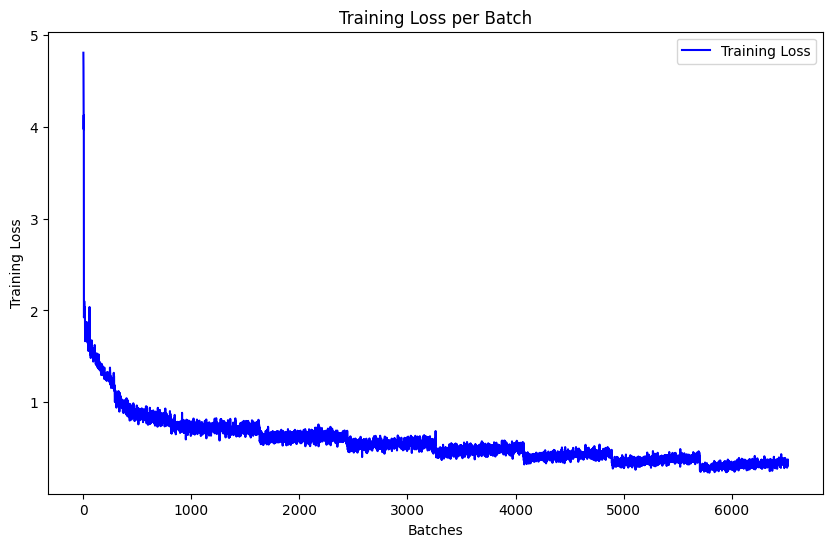

In [ ]:
# Training Loss per Batch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses_per_batch) + 1), training_losses_per_batch, label="Training Loss", color='b')
plt.xlabel("Batches")
plt.ylabel("Training Loss")
plt.title("Training Loss per Batch")
plt.legend()
plt.savefig(f"{file_path_prefix}/results/training_loss_per_batch_v3.png")
plt.show()

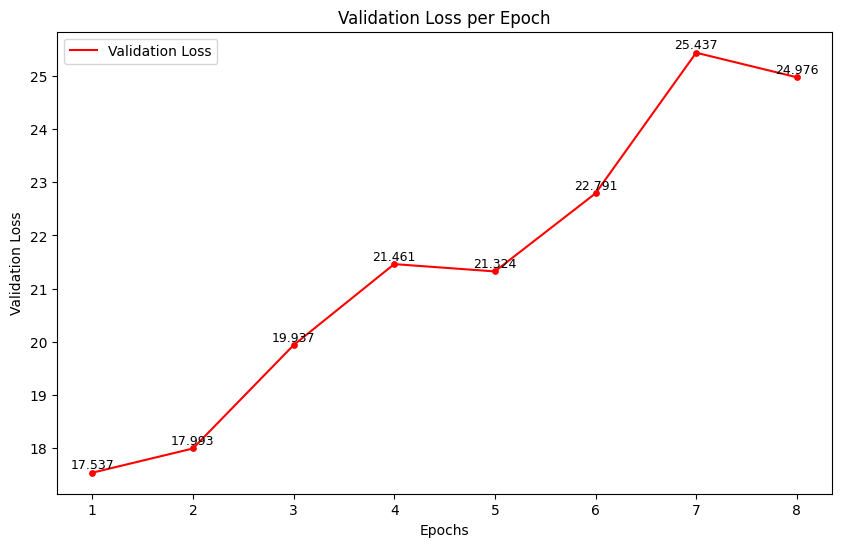

In [ ]:
# Validation Loss per Epoch
plt.figure(figsize=(10, 6))
epochs = range(1, len(validation_losses_per_epoch) + 1)
plt.plot(epochs, validation_losses_per_epoch, label="Validation Loss", color='r')
plt.scatter(epochs, validation_losses_per_epoch, color='r', s=15)  # Show data points

# Annotate each point with its actual value
for x, y in zip(epochs, validation_losses_per_epoch):
    plt.text(x, y+0.02, f'{y:.3f}', fontsize=9, ha='center', va='bottom')

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Epoch")
plt.legend()
plt.savefig(f"{file_path_prefix}/results/validation_loss_per_epoch_v3.png")
plt.show()

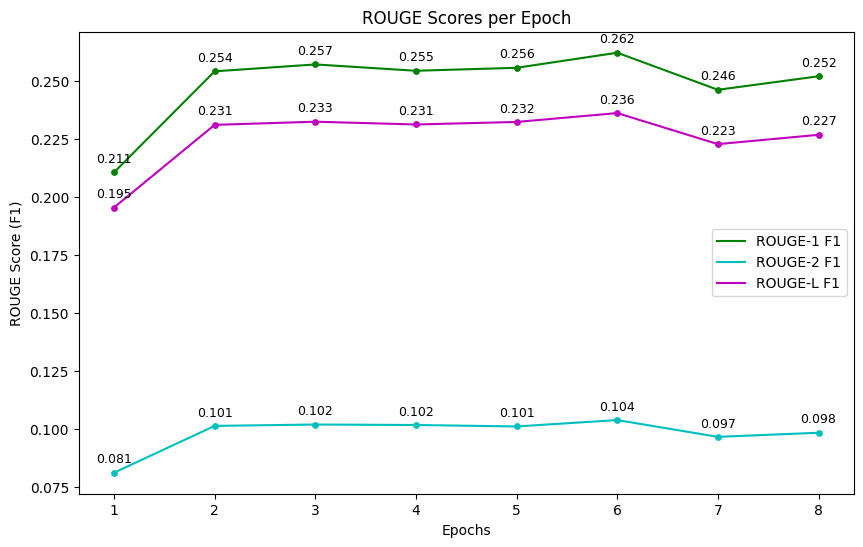

In [ ]:
# ROUGE Scores per Epoch
rouge_1_f1 = [score['rouge-1']['f'] for score in rouge_scores_per_epoch]
rouge_2_f1 = [score['rouge-2']['f'] for score in rouge_scores_per_epoch]
rouge_l_f1 = [score['rouge-l']['f'] for score in rouge_scores_per_epoch]

epochs = range(1, len(rouge_1_f1) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, rouge_1_f1, label="ROUGE-1 F1", color='g')
plt.scatter(epochs, rouge_1_f1, color='g', s=15)  # Show data points for ROUGE-1
for x, y in zip(epochs, rouge_1_f1):
    plt.text(x, y+0.003, f'{y:.3f}', fontsize=9, ha='center', va='bottom')

plt.plot(epochs, rouge_2_f1, label="ROUGE-2 F1", color='c')
plt.scatter(epochs, rouge_2_f1, color='c', s=15)  # Show data points for ROUGE-2
for x, y in zip(epochs, rouge_2_f1):
    plt.text(x, y+0.003, f'{y:.3f}', fontsize=9, ha='center', va='bottom')

plt.plot(epochs, rouge_l_f1, label="ROUGE-L F1", color='m')
plt.scatter(epochs, rouge_l_f1, color='m', s=15)  # Show data points for ROUGE-L
for x, y in zip(epochs, rouge_l_f1):
    plt.text(x, y+0.003, f'{y:.3f}', fontsize=9, ha='center', va='bottom')

plt.xlabel("Epochs")
plt.ylabel("ROUGE Score (F1)")
plt.title("ROUGE Scores per Epoch")
plt.legend()
plt.savefig(f"{file_path_prefix}/results/rouge_scores_per_epoch_v3.png")
plt.show()

## Evaluation

In [ ]:
from argparse import Namespace

args = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_6.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "use_adafactor": True
}

args = Namespace(**args)

# Now you can access attributes using dot notation
print(args.model_name)

google/mt5-small


In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Initialize Accelerator
accelerator = Accelerator()

# Load pre-trained multilingual T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(args.tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(args.model_name)
state_dict = torch.load(args.model_path, map_location=device)
model.load_state_dict(state_dict)

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
<ipython-input-31-1bf7a5bf40b8>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub f

<All keys matched successfully>

In [ ]:
# Prepare dataset
# Define dataset class
class NewsSummaryDatasetForEval(Dataset):
    def __init__(self, filepath, tokenizer, max_input_length=256, max_output_length=64):
        self.data = []
        with open(filepath, "r", encoding="utf-8") as f:
            for idx, line in enumerate(f):
                self.data.append(json.loads(line))
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        id = item["id"]
        maintext = item["maintext"]
        title = item["title"]
        inputs = self.tokenizer(
            maintext,
            max_length=self.max_input_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        labels = self.tokenizer(
            title,
            max_length=self.max_output_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels["input_ids"].squeeze(),
            "id": id
        }

eval_dataset = NewsSummaryDataset(
    filepath=args.eval_dataset_path,
    tokenizer=tokenizer,
    max_input_length=args.max_input_length,
    max_output_length=args.max_output_length,
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=args.batch_size, shuffle=False
)

In [35]:
import json
from tqdm import tqdm

# Evaluation loop on the evaluation dataset
# Prepare model and optimizer
model, eval_dataloader = accelerator.prepare(
    model,
    eval_dataloader,
)
device = accelerator.device
model.eval()
model.to(device)
eval_loss = 0
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args.max_output_length,
            num_beams=5,
            early_stopping=True,
            temperature=1.0,
            top_p=0.95,
            top_k=50
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args.submission_path}")

Evaluating: 100%|██████████| 687/687 [09:01<00:00,  1.27it/s]

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_6.jsonl


In [36]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args.submission_path}

2024-10-22 07:14:21.851339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 07:14:21.873950: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 07:14:21.880538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 07:14:23.016918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by

In [ ]:
args = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_5.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_5.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_5",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "use_adafactor": True
}

args = Namespace(**args)

In [ ]:
# Evaluation loop on the evaluation dataset
import json
from tqdm import tqdm
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Initialize Accelerator
accelerator = Accelerator()

# Prepare model and optimizer
# Load pre-trained multilingual T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(args.tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(args.model_name)

eval_dataset = NewsSummaryDataset(
    filepath=args.eval_dataset_path,
    tokenizer=tokenizer,
    max_input_length=args.max_input_length,
    max_output_length=args.max_output_length,
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=args.batch_size, shuffle=False
)

model, eval_dataloader = accelerator.prepare(
    model,
    eval_dataloader,
)

device = accelerator.device
state_dict = torch.load(args.model_path, map_location=device)
model.load_state_dict(state_dict)

model.eval()
model.to(device)
eval_loss = 0
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args.max_output_length,
            num_beams=5,
            early_stopping=True,
            temperature=1.0,
            top_p=0.95,
            top_k=50
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args.submission_path}")

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
<ipython-input-27-8e25de9c6d7a>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_5.jsonl


In [ ]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args.submission_path}

2024-10-22 06:53:54.035219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 06:53:54.058270: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 06:53:54.064852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 06:53:55.220229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by

In [37]:
args = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_7.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_7.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_7",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "use_adafactor": True
}

args = Namespace(**args)

In [38]:
# Evaluation loop on the evaluation dataset
import json
from tqdm import tqdm
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Initialize Accelerator
accelerator = Accelerator()

# Prepare model and optimizer
# Load pre-trained multilingual T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(args.tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(args.model_name)

eval_dataset = NewsSummaryDataset(
    filepath=args.eval_dataset_path,
    tokenizer=tokenizer,
    max_input_length=args.max_input_length,
    max_output_length=args.max_output_length,
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=args.batch_size, shuffle=False
)

model, eval_dataloader = accelerator.prepare(
    model,
    eval_dataloader,
)

device = accelerator.device
state_dict = torch.load(args.model_path, map_location=device)
model.load_state_dict(state_dict)

model.eval()
model.to(device)
eval_loss = 0
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args.max_output_length,
            num_beams=5,
            early_stopping=True,
            temperature=1.0,
            top_p=0.95,
            top_k=50
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args.submission_path}")

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
<ipython-input-38-8e25de9c6d7a>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_7.jsonl


In [39]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args.submission_path}

2024-10-22 08:35:38.224737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 08:35:38.247116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 08:35:38.253739: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 08:35:39.435729: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by

## Try Different Generating Strategies

In [41]:
# temperature = 0
args_alternate_1 = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_6_temp0.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "num_beams": 5,
    "early_stopping": True,
    "temperature": 0,
    "top_p": 0.95,
    "top_k": 50
}

# greedy
args_alternate_2 = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_6_greedy.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "early_stopping": True,
}



args_alternate_1 = Namespace(**args_alternate_1)
args_alternate_2 = Namespace(**args_alternate_2)

In [42]:
# Evaluation loop on the evaluation dataset
import json
from tqdm import tqdm
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Initialize Accelerator
accelerator = Accelerator()

# Prepare model and optimizer
# Load pre-trained multilingual T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(args.tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(args.model_name)

eval_dataset = NewsSummaryDataset(
    filepath=args.eval_dataset_path,
    tokenizer=tokenizer,
    max_input_length=args.max_input_length,
    max_output_length=args.max_output_length,
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=args.batch_size, shuffle=False
)

model, eval_dataloader = accelerator.prepare(
    model,
    eval_dataloader,
)

device = accelerator.device
state_dict = torch.load(args.model_path, map_location=device)
model.load_state_dict(state_dict)

model.eval()
model.to(device)

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
<ipython-input-42-56ca80e8edfb>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

T5ForConditionalGeneration(
  (shared): Embedding(250112, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(250112, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo)

In [44]:
eval_loss = 0
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args_alternate_1.max_output_length,
            num_beams=args_alternate_1.num_beams,
            early_stopping=args_alternate_1.early_stopping,
            temperature=args_alternate_1.temperature,
            top_p=args_alternate_1.top_p,
            top_k=args_alternate_1.top_k
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args_alternate_1.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args_alternate_1.submission_path}")

Evaluating:   0%|          | 0/687 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Evaluating: 100%|██████████| 687/687 [08:53<00:00,  1.29it/s]

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_6.jsonl


In [45]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args_alternate_1.submission_path}

2024-10-22 08:48:23.611116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 08:48:23.632620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 08:48:23.639081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 08:48:24.771595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by

In [46]:
eval_loss = 0
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args_alternate_2.max_output_length,
            early_stopping=args_alternate_2.early_stopping,
            do_sample=False # greedy
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args_alternate_2.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args_alternate_2.submission_path}")

Evaluating:   0%|          | 0/687 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Evaluating: 100%|██████████| 687/687 [05:57<00:00,  1.92it/s]

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_6.jsonl


In [47]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args_alternate_2.submission_path}

2024-10-22 08:54:34.346591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 08:54:34.368867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 08:54:34.375365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 08:54:35.537321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by

In [28]:
# num of beams
args_alternate_beam3 = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_6_beam3.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "num_beams": 3,
    "early_stopping": True,
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 50
}

args_alternate_beam10 = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_6_beam10.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "num_beams": 10,
    "early_stopping": True,
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 50
}

args_alternate_beam15 = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_6_beam15.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "num_beams": 15,
    "early_stopping": True,
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 50
}

args_alternate_beam20 = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_6_beam20.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "num_beams": 20,
    "early_stopping": True,
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 50
}
args_alternate_beam3 = Namespace(**args_alternate_beam3)
args_alternate_beam10 = Namespace(**args_alternate_beam10)
args_alternate_beam15 = Namespace(**args_alternate_beam15)
args_alternate_beam20 = Namespace(**args_alternate_beam20)


In [13]:
# Evaluation loop on the evaluation dataset
import json
from tqdm import tqdm
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Initialize Accelerator
accelerator = Accelerator()

# Prepare model and optimizer
# Load pre-trained multilingual T5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(args_alternate_beam3.tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(args_alternate_beam3.model_name)

eval_dataset = NewsSummaryDataset(
    filepath=args_alternate_beam3.eval_dataset_path,
    tokenizer=tokenizer,
    max_input_length=args_alternate_beam3.max_input_length,
    max_output_length=args_alternate_beam3.max_output_length,
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=args_alternate_beam3.batch_size, shuffle=False
)

model, eval_dataloader = accelerator.prepare(
    model,
    eval_dataloader,
)

device = accelerator.device
state_dict = torch.load(args_alternate_beam3.model_path, map_location=device)
model.load_state_dict(state_dict)

model.eval()
model.to(device)
eval_loss = 0
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args_alternate_beam3.max_output_length,
            num_beams=args_alternate_beam3.num_beams,
            early_stopping=args_alternate_beam3.early_stopping,
            temperature=args_alternate_beam3.temperature,
            top_p=args_alternate_beam3.top_p,
            top_k=args_alternate_beam3.top_k
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args_alternate_beam3.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args_alternate_beam3.submission_path}")

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.
<ipython-input-13-eaf9809d2920>:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_6_beam3.jsonl


In [14]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args_alternate_beam3.submission_path}

2024-10-22 12:56:31.753153: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 12:56:31.771448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 12:56:31.792622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 12:56:31.799133: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 12:56:31.814704: I tensorflow/core/platform/cpu_feature_guar

In [15]:

model.eval()
model.to(device)
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args_alternate_beam10.max_output_length,
            num_beams=args_alternate_beam10.num_beams,
            early_stopping=args_alternate_beam10.early_stopping,
            temperature=args_alternate_beam10.temperature,
            top_p=args_alternate_beam10.top_p,
            top_k=args_alternate_beam10.top_k
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args_alternate_beam10.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args_alternate_beam10.submission_path}")

Evaluating:   0%|          | 0/687 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Evaluating: 100%|██████████| 687/687 [10:45<00:00,  1.06it/s]

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_6_beam10.jsonl


In [16]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args_alternate_beam10.submission_path}

2024-10-22 13:08:01.592724: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 13:08:01.611280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 13:08:01.632956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 13:08:01.639554: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 13:08:01.655304: I tensorflow/core/platform/cpu_feature_guar

In [29]:

model.eval()
model.to(device)
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args_alternate_beam15.max_output_length,
            num_beams=args_alternate_beam15.num_beams,
            early_stopping=args_alternate_beam15.early_stopping,
            temperature=args_alternate_beam15.temperature,
            top_p=args_alternate_beam15.top_p,
            top_k=args_alternate_beam15.top_k
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args_alternate_beam15.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args_alternate_beam15.submission_path}")

Evaluating:   0%|          | 0/687 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Evaluating: 100%|██████████| 687/687 [12:52<00:00,  1.12s/it]

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_6_beam15.jsonl


In [30]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args_alternate_beam15.submission_path}

2024-10-22 14:25:48.311255: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 14:25:48.330425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 14:25:48.351602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 14:25:48.358305: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 14:25:48.373711: I tensorflow/core/platform/cpu_feature_guar

In [31]:

model.eval()
model.to(device)
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args_alternate_beam20.max_output_length,
            num_beams=args_alternate_beam20.num_beams,
            early_stopping=args_alternate_beam20.early_stopping,
            temperature=args_alternate_beam20.temperature,
            top_p=args_alternate_beam20.top_p,
            top_k=args_alternate_beam20.top_k
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args_alternate_beam20.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args_alternate_beam20.submission_path}")

Evaluating:   0%|          | 0/687 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Evaluating: 100%|██████████| 687/687 [15:16<00:00,  1.33s/it]

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_6_beam20.jsonl


In [32]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args_alternate_beam20.submission_path}

2024-10-22 14:41:17.546705: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 14:41:17.565759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 14:41:17.587699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 14:41:17.594224: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 14:41:17.609753: I tensorflow/core/platform/cpu_feature_guar

### Top k

In [17]:
# top k
args_alternate_topk30 = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_6_topk30.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "num_beams": 5,
    "early_stopping": True,
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 30
}

args_alternate_topk70 = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_6_topk70.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "num_beams": 5,
    "early_stopping": True,
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 70
}

args_alternate_topk30 = Namespace(**args_alternate_topk30)
args_alternate_topk70 = Namespace(**args_alternate_topk70)

In [21]:
model.eval()
model.to(device)
eval_loss = 0
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args_alternate_topk30.max_output_length,
            num_beams=args_alternate_topk30.num_beams,
            early_stopping=args_alternate_topk30.early_stopping,
            temperature=args_alternate_topk30.temperature,
            top_p=args_alternate_topk30.top_p,
            top_k=args_alternate_topk30.top_k
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args_alternate_topk30.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args_alternate_topk30.submission_path}")

Evaluating:   0%|          | 0/687 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:589: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `30` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Evaluating: 100%|██████████| 687/687 [08:30<00:00,  1.35it/s]

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_6_topk30.jsonl


In [22]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args_alternate_topk30.submission_path}

2024-10-22 13:30:37.199829: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 13:30:37.217907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 13:30:37.239080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 13:30:37.245507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 13:30:37.260772: I tensorflow/core/platform/cpu_feature_guar

In [18]:
model.eval()
model.to(device)
eval_loss = 0
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args_alternate_topk70.max_output_length,
            num_beams=args_alternate_topk70.num_beams,
            early_stopping=args_alternate_topk70.early_stopping,
            temperature=args_alternate_topk70.temperature,
            top_p=args_alternate_topk70.top_p,
            top_k=args_alternate_topk70.top_k
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args_alternate_topk70.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args_alternate_topk70.submission_path}")

Evaluating:   0%|          | 0/687 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:589: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `70` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Evaluating: 100%|██████████| 687/687 [08:31<00:00,  1.34it/s]

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_6_topk70.jsonl


In [19]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args_alternate_topk70.submission_path}

2024-10-22 13:16:46.389450: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 13:16:46.407739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 13:16:46.429443: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 13:16:46.435973: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 13:16:46.451690: I tensorflow/core/platform/cpu_feature_guar

### Top p

In [23]:
# top p
args_alternate_topp75 = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_6_topp75.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "num_beams": 5,
    "early_stopping": True,
    "temperature": 1,
    "top_p": 0.75,
    "top_k": 50
}

args_alternate_topp50 = {
    "model_name": "google/mt5-small",
    "eval_dataset_path": f"{file_path_prefix}/data/public.jsonl",
    "submission_path": f"{file_path_prefix}/data/submission_v3_epoch_6_topp50.jsonl",
    "model_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6.pth",
    "tokenizer_path": f"{file_path_prefix}/models/fine_tuned_mt5_v3_epoch_6",
    "batch_size": 8,
    "max_input_length": 512,
    "max_output_length": 100,
    "num_beams": 5,
    "early_stopping": True,
    "temperature": 1,
    "top_p": 0.50,
    "top_k": 50
}

args_alternate_topp50 = Namespace(**args_alternate_topp50)
args_alternate_topp75 = Namespace(**args_alternate_topp75)

In [24]:
model.eval()
model.to(device)
eval_loss = 0
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args_alternate_topp50.max_output_length,
            num_beams=args_alternate_topp50.num_beams,
            early_stopping=args_alternate_topp50.early_stopping,
            temperature=args_alternate_topp50.temperature,
            top_p=args_alternate_topp50.top_p,
            top_k=args_alternate_topp50.top_k
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args_alternate_topp50.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args_alternate_topp50.submission_path}")

Evaluating:   0%|          | 0/687 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Evaluating: 100%|██████████| 687/687 [08:31<00:00,  1.34it/s]

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_6_topp50.jsonl


In [25]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args_alternate_topp50.submission_path}

2024-10-22 13:50:11.662844: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 13:50:11.681051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 13:50:11.702649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 13:50:11.709385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 13:50:11.724993: I tensorflow/core/platform/cpu_feature_guar

In [26]:
model.eval()
model.to(device)
eval_loss = 0
results = []

# Add progress bar for evaluation
with torch.no_grad():
    progress_bar = tqdm(eval_dataloader, desc="Evaluating")
    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        ids = batch["id"]  # Assuming 'id' is included in your dataset batches for identification

        # Generate predictions
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=args_alternate_topp75.max_output_length,
            num_beams=args_alternate_topp75.num_beams,
            early_stopping=args_alternate_topp75.early_stopping,
            temperature=args_alternate_topp75.temperature,
            top_p=args_alternate_topp75.top_p,
            top_k=args_alternate_topp75.top_k
        )

        # Decode predictions
        decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        # Format each prediction and add it to results
        for i, title in enumerate(decoded_preds):
            result = {
                "title": title,
                "id": ids[i]
            }
            results.append(result)

# Write results to the submission file in the required format
with open(args_alternate_topp75.submission_path, "w", encoding="utf-8") as f:
    for result in results:
        json.dump(result, f, ensure_ascii=False)
        f.write("\n")

print(f"Submission file saved to: {args_alternate_topp75.submission_path}")

Evaluating:   0%|          | 0/687 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.75` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Evaluating: 100%|██████████| 687/687 [08:30<00:00,  1.35it/s]

Submission file saved to: /content/drive/MyDrive/ADL/hw2/data/submission_v3_epoch_6_topp75.jsonl


In [27]:
!python {file_path_prefix}/evaluation/eval.py -r {file_path_prefix}/data/public.jsonl -s {args_alternate_topp75.submission_path}

2024-10-22 13:58:54.714498: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 13:58:54.732520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 13:58:54.753848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 13:58:54.760314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 13:58:54.775634: I tensorflow/core/platform/cpu_feature_guar